In [45]:
# This should install any required dependencies assuming jax has already been installed
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import numpyro
except ImportError:
    %pip install -q numpyro
    
try:
    import corner
except ImportError:
    %pip install -q corner
    
try:
    import arviz as az
except ImportError:
    %pip install -q arviz

(numpyro_example)=

# NumPyro Example: Transmission Spectroscopy

*NOTE: This tutorial notebook is currently in development. Expect significant changes in the future*

This notebook provides to tutorial on how to use ``NumPyro`` to perform spectroscopic transit light curve fitting. We will first go through how to generate transit light curves in ``JAX``, then we will create synthetic noise which will be correlated in both wavelength and time. Finally we will use ``NumPyro`` to fit the noise contaminated light curves and recover the input transmission spectrum.

``NumPyro`` has the advantage of being written in ``jax`` which makes implementing some things with ``luas`` like parallelisation simpler compared to ``PyMC``. However, arguably it is less user-friendly than ``PyMC`` and has less flexibility at times. For example, unlike ``PyMC`` blocked Gibbs sampling is difficult to implement, in addition there are less options for using non-gradient based MCMC methods such as slice sampling.

If you have a GPU available (including if running on Google Colab) then ``jax`` should detect this and run automatically. Running ``jax.devices()`` tells us what ``jax`` has found to run on. If there is a GPU available but it is not detected this could indicate ``jax`` has not been correctly installed for GPU. Also note if running on Google Colab that the T4 GPUs have poor performance at double precision floating point and may not show significant speed-ups, while more modern hardware such as NVIDIA Tesla V100s or better tend to show significant performance improvements

In [46]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
from jaxoplanet.orbits import KeplerianOrbit
from jaxoplanet.light_curves import QuadLightCurve
import arviz as az
import pandas as pd
import luas
import numpyro
import corner
import logging
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# This helps give more information on what NumPyro is doing during inference
logging.getLogger().setLevel(logging.INFO)

# Running this at the start of the runtime ensures jax uses 64-bit floating point numbers
# as jax uses 32-bit by default
jax.config.update("jax_enable_x64", True)

# This will list available CPUs/GPUs JAX is picking up
print("Available devices:", jax.devices())

Available devices: [CpuDevice(id=0)]


First we will use [jaxoplanet](https://github.com/exoplanet-dev/jaxoplanet) which has its own documentation and tutorials [here](https://jax.exoplanet.codes/en/latest/). Let's create a single light curve with quadratic limb darkening. We will use the ``transit_light_curve`` function from ``luas.exoplanet`` which we have included below to show what it does

In [47]:
def transit_light_curve(par, t):
    """Uses the package `jaxoplanet <https://github.com/exoplanet-dev/jaxoplanet>`_ to calculate
    transit light curves using JAX assuming quadratic limb darkening and a simple circular orbit.
    
    This particular function will only compute a single transit light curve but JAX's vmap function
    can be used to calculate the transit light curve of multiple wavelength bands at once.
    
    Args:
        par (PyTree): The transit parameters stored in a PyTree/dictionary (see example above).
        t (JAXArray): Array of times to calculate the light curve at.
            
    Returns:
        JAXArray: Array of flux values for each time input.
        
    """
    
    light_curve = QuadLightCurve.init(u1=par["u1"], u2=par["u2"])
    orbit = KeplerianOrbit.init(
        time_transit=par["T0"],
        period=par["P"],
        semimajor=par["a"],
        impact_param=par["b"],
        radius=par["rho"],
    )
    
    flux = (par["Foot"] + 24*par["Tgrad"]*(t-par["T0"]))*(1+light_curve.light_curve(orbit, t)[0])
    
    return flux

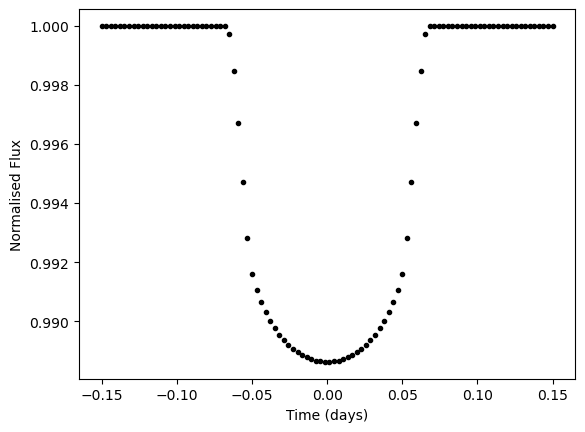

In [48]:
from luas.exoplanet import transit_light_curve

# Let's use the literature values used in Gibson et al. (2017) to start us off
mfp = {
    "T0":0.,     # Central transit time
    "P":3.4,     # Period (days)
    "a":8.,      # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1,   # Radius ratio rho aka Rp/R*
    "b":0.5,     # Impact parameter
    "u1":0.5,    # First quadratic limb darkening coefficient
    "u2":0.1,    # Second quadratic limb darkening coefficient
    "Foot":1.,   # Baseline flux out of transit
    "Tgrad":0.   # Gradient in baseline flux (hrs^-1)
}

# Generate 100 evenly spaced time points (in units of days)
N_t = 100
x_t = jnp.linspace(-0.15, 0.15, N_t)

plt.plot(x_t, transit_light_curve(mfp, x_t), "k.")
plt.xlabel("Time (days)")
plt.ylabel("Normalised Flux")
plt.show()

Now we want to take our ``jax`` function which has been written to generate a 1D light curve in time and instead create separate light curves in each wavelength. We also will want to share some parameters between light curves (e.g. impact parameter b, system scale a/Rs) while varying other parameters for each wavelength (e.g. radius ratio Rp/Rs).

We could of course write a ``for`` loop but ``for`` loops can be slow to compile with ``jax``. A much more efficient option is to make use of the ``jax.vmap`` function which allows us to "vectorise" our function from 1D to 2D:

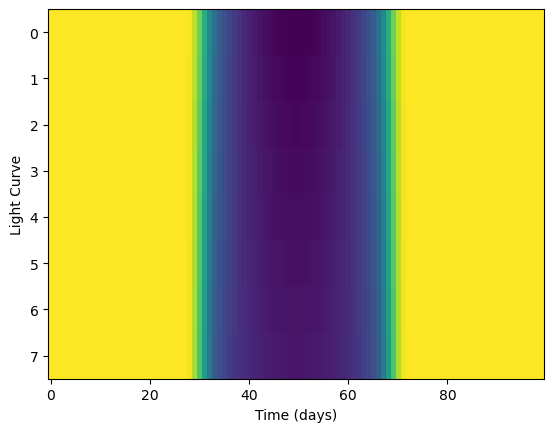

In [49]:
# First we must tell JAX which parameters of the function we want to vary for each light curve
# and which we want to be shared between light curves
transit_light_curve_vmap = jax.vmap(
    # First argument is the function to vectorise
    transit_light_curve, 
    
    # Specify which parameters to share and which to vary for each light curve
    in_axes=(
        {
        # If a parameter is to be shared across each light curve then it should be set to None
        "T0":None, "P":None, "a":None, "b":None,

        # Parameters which vary in wavelength are given the dimension of the array to expand along
        # In this case we are expanding from 0D arrays to 1D arrays so this must be 0
        "rho":0, "u1":0, "u2":0, "Foot":0, "Tgrad":0
        },
        # Also must specify that we will share the time array (the second function parameter)
        # between light curves
         None,  
    ),
    
    # Specify the output dimension to expand along, this will default to 0 anyway
    # Will output extra flux values for each light curve as additional rows
    out_axes = 0,
)

# Let's define a wavelength range of our data, this isn't actually used by our mean function
# but we will use it for defining correlation in wavelength later
N_l = 8 # Feel free to vary the number of light curves, even >100 light curves may perform quite efficiently
x_l = np.linspace(4000, 7000, N_l)

# Now we define our 2D transit parameters, let's just assume everything is constant in wavelength
# Note that the parameters which vary in wavelength are now arrays of size N_l
mfp_2D = {
    "T0":0.,                         # Central transit time
    "P":3.4,                         # Period (days)
    "a":8.,                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5,                         # Impact parameter
    "u1":np.linspace(0.7, 0.4, N_l), # First quadratic limb darkening coefficient
    "u2":np.linspace(0.1, 0.2, N_l), # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l)          # Gradient in baseline flux (days^-1)
}

# Call our new vmap of transit_light_curve to simultaneously compute light curves for all wavelengths
transit_model_2D = transit_light_curve_vmap(mfp_2D, x_t)

# Plot the data on the left and the multiwavelength model on the right
plt.imshow(transit_model_2D, aspect = 'auto')
plt.xlabel("Time (days)")
plt.ylabel("Light Curve")
plt.show()

The form of a mean function with ``luas.GP`` is ``f(par, x_l, x_t)`` where ``par`` is a PyTree, ``x_l`` is a JAXArray of inputs that lie along the wavelength/vertical dimension of the data (e.g. an array of wavelength values) and ``x_t`` is a JAXArray of inputs that lie along the time/horizontal dimension (e.g. an array of timestamps). Our transit model does not require wavelength values to be computed but we still write our wrapper function to be of this form.

We will also switch to the [Kipping (2013)](https://arxiv.org/abs/1308.0009) limb darkening parameterisation as it makes it easier to place simple bounds on these parameters and also places uniform priors on the physically allowed space of limb darkening parameters

Note our ``jax.vmap`` function specifies exactly the keys that must be in the input PyTree for ``transit_light_curve_vmap`` so we also filter only these parameters to be input into the ``transit_light_curve_vmap`` function. Feel free to use the ``luas.exoplanet.transit_2D`` function instead which is similar to the below function with the exception that it fits for transit depth instead of radius ratio

In [50]:
from luas.exoplanet import ld_to_kipping, ld_from_kipping

def transit_light_curve_2D(p, x_l, x_t):
    
    # vmap requires that we only input the parameters which have been explicitly defined how they vectorise
    transit_params = ["T0", "P", "a", "rho", "b", "Foot", "Tgrad"]
    mfp = {k:p[k] for k in transit_params}
    
    # Calculate limb darkening coefficients from the Kipping (2013) parameterisation.
    mfp["u1"], mfp["u2"] = ld_from_kipping(p["q1"], p["q2"])
    
    # Use the vmap of transit_light_curve to calculate a 2D array of shape (M, N) of flux values
    # For M wavelengths and N time points.
    return transit_light_curve_vmap(mfp, x_t)


# Switch to Kipping parameterisation
if "u1" in mfp_2D:
    mfp_2D["q1"], mfp_2D["q2"] = ld_to_kipping(mfp_2D["u1"], mfp_2D["u2"])
    del mfp_2D["u1"]
    del mfp_2D["u2"]

# This should produce the same result as transit_light_curve_vmap as we have only changed the limb darkening parameterisation
M = transit_light_curve_2D(mfp_2D, x_l, x_t)

Now that we have our mean function created, it's time to start building a kernel function. We will try keep things simple and use a squared exponential kernel for correlation in both time and wavelength, and white noise which varies in amplitude between light curves

$$
\begin{equation}
\mathbf{K}_{ij} = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j} \delta_{t_i t_j}
\end{equation}
$$

This kernel contains a correlated noise component with height scale $h$, length scale in wavelength $l_\mathrm{\lambda}$ and length scale in time $l_t$. There is also a white noise term which can have different white noise amplitudes at different wavelengths.

We will need to write this kernel as separate wavelength and time kernel functions multiplied together satisfying:
$$
\begin{equation}
\text{K}(\Delta \lambda, \Delta t) = \text{K}_{l}(\Delta \lambda) \otimes \text{K}_{t}(\Delta t) + \text{S}_{l}(\Delta \lambda) \otimes \text{S}_{t}(\Delta t)
\end{equation}
$$

We can do this by choosing the equations below for our kernel functions which generate each component matrix. Note that for numerical stability reasons it's important that the $S_l$ and $S_t$ matrices are well-conditioned while $K_l$ and $K_t$ do not need to be well-conditioned and in fact don't even need to be invertible (they still must be positive semi-definite and symmetric)
$$
\begin{equation}
    \text{K}_l(\lambda_i, \lambda_j) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) 
\end{equation}
$$

$$
\begin{equation}
    \text{K}_t(t_i, t_j) = \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right)
\end{equation}
$$

$$
\begin{equation}
    \text{S}_l(\lambda_i, \lambda_j) = \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}
\end{equation}
$$

$$
\begin{equation}
    \text{S}_t(t_i, t_j) = \delta_{t_i t_j}
\end{equation}
$$

In [51]:
from luas import kernels
from luas import LuasKernel

# We implement each of these kernel functions below using the luas.kernels module
# for an implementation of the squared exponential kernel

# The wavelength kernel functions take the wavelength regression variables x_l as input

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.exp(2*hp["log_h"])*kernels.squared_exp(x_l1, x_l2, jnp.exp(hp["log_l_l"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return kernels.squared_exp(x_t1, x_t2, jnp.exp(hp["log_l_t"]))

# For both the Sl and St functions we set a decomp attribute to "diag" because they produce diagonal matrices
# This speeds up the log likelihood calculations as it tells luas these matrices are easy to eigendecompose
# But don't do this for the Kl and Kt functions even if they produce diagonal matrices unless you know what you are doing
# This is because you are telling luas that the transformations of Kl and Kt are diagonal, not Kl and Kt themselves

# If the wn keyword argument is True then white noise should be included (doesn't affect most matrices)
# This is used by gp.predict when performing Gaussian process prediction
def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.zeros((x_l1.shape[-1], x_l2.shape[-1]))
    
    if wn:
        # If we are including white noise then safe to assume Sl is a square matrix for any calculations in luas.GP
        Sl += jnp.diag(jnp.exp(2*hp["log_sigma"])) # Assumes hp["log_sigma"] is an array of size N_l

    return Sl
Sl_fn.decomp = "diag" # Sl is a diagonal matrix

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag" # St is a diagonal matrix

# Build a LuasKernel object using these component kernel functions
# The full covariance matrix applied to the data will be K = Kl KRON Kt + Sl KRON St
kernel = LuasKernel(Kl = Kl_fn, Kt = Kt_fn, Sl = Sl_fn, St = St_fn,
                    
                    # Can select whether to use previously calculated eigendecompositions when running MCMC
                    # Performs an additional check in each step to see if each component covariance matrix has changed since last step
                    # Useful when doing blocked Gibbs or if fixing some hyperparameters
                    use_stored_values = True, 
                   )

The ``LuasKernel.visualise_covariance_matrix`` method should be a useful way of visualising each of the four component matrices and ensure everything you have written looks right

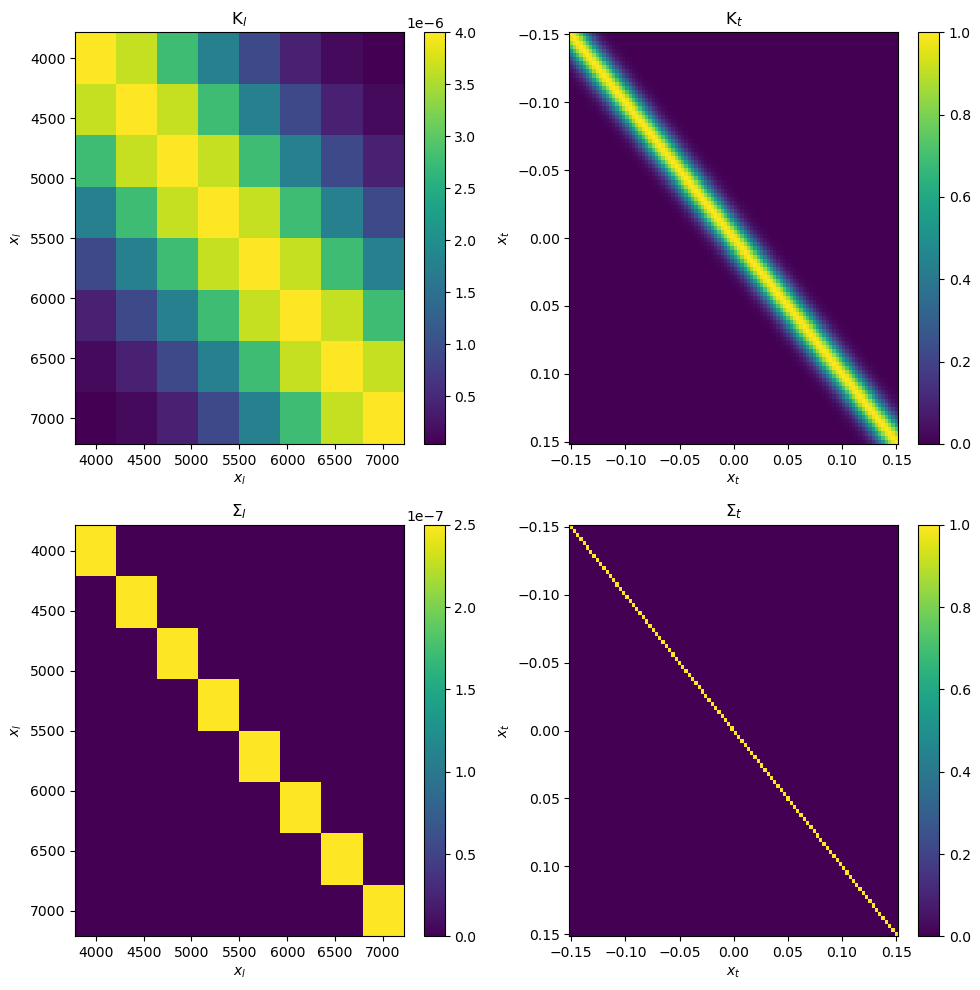

In [52]:
# Some sample hyperparameters
hp = {
    "log_h":jnp.log(2e-3),    # log height scale of correlated noise
    "log_l_l":jnp.log(1000.), # log wavelength length scale
    "log_l_t":jnp.log(0.011), # log time length scale
    "log_sigma":jnp.log(5e-4)*jnp.ones(N_l), # white noise amplitude at each wavelength
}

kernel.visualise_covariance_matrix(hp, x_l, x_t);

Take a random noise draw from this covariance matrix. Try playing around with these values to see the effect varying each parameter has on the noise generated.

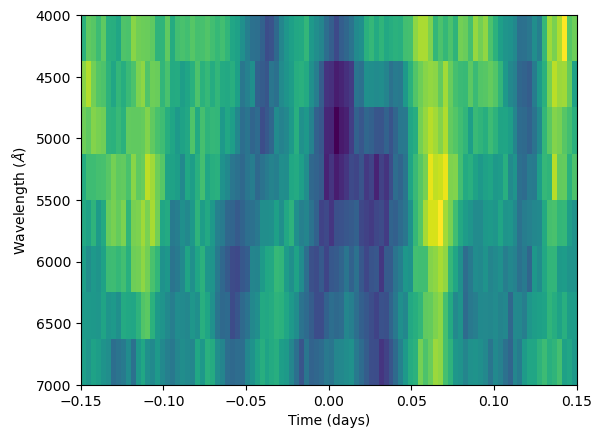

In [53]:
hp = {"log_h":jnp.log(2e-3), "log_l_l":jnp.log(1000.), "log_l_t":jnp.log(0.011),
      "log_sigma":jnp.log(5e-4)*jnp.ones(N_l),}

sim_noise = kernel.generate_noise(hp, x_l, x_t)

plt.imshow(sim_noise, aspect = 'auto', extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

Combining our light curves and noise model we can generate synthetic light curves contaminated by systematics correlated in time and wavelength

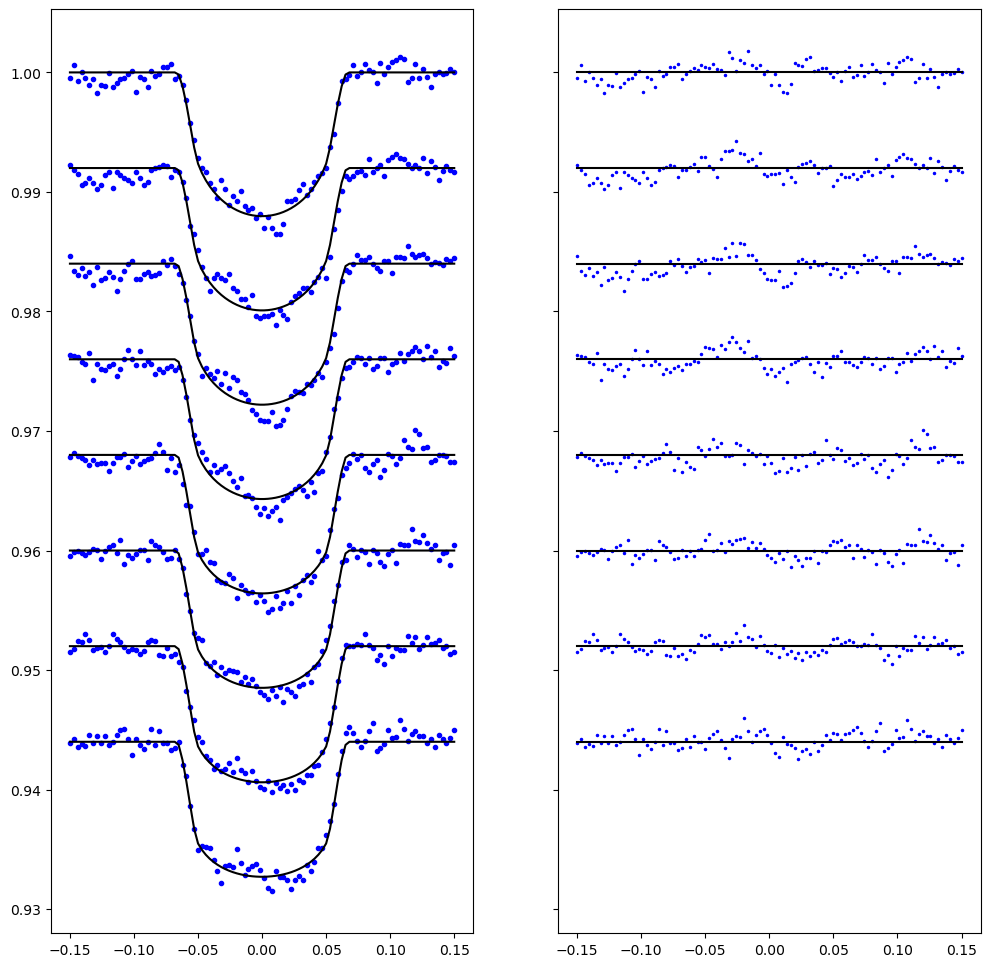

In [54]:
def plot_lightcurves(x_t, M, Y, sep = 0.008):
    """Quick function to visualise light curves and the residuals after subtraction of transit model
    
    """
    N_l = x_l.shape[-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharey = True)
    for i in range(N_l):
        ax1.plot(x_t, Y[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'bo', ms = 3)
        
        ax1.plot(x_t, M[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'k-', ms = 3)
        ax2.plot(x_t, Y[i, :] - M[i, :] + np.arange(1, 1-sep*N_l, -sep)[i], 'b.', ms = 3)
        ax2.plot(x_t, np.arange(1, 1-sep*N_l, -sep)[i]*np.ones_like(x_t), 'k-', ms = 3)

u1_sim, u2_sim = jnp.linspace(0.7, 0.4, N_l), jnp.linspace(0.1, 0.2, N_l)
q1_sim, q2_sim = ld_to_kipping(u1_sim, u2_sim)

# All parameters used to generate the synthetic data set with noise
p_sim = {
    "T0":0.*jnp.ones(1),                         # Central transit time
    "P":3.4*jnp.ones(1),                         # Period (days)
    "a":8.*jnp.ones(1),                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*jnp.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5*jnp.ones(1),                       # Impact parameter
    "q1":q1_sim, # First quadratic limb darkening coefficient
    "q2":q2_sim, # Second quadratic limb darkening coefficient
    "Foot":1.*jnp.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*jnp.ones(N_l),          # Gradient in baseline flux (days^-1)
    "log_h":jnp.log(5e-4)*jnp.ones(1),
    "log_l_l":jnp.log(1000.)*jnp.ones(1),
    "log_l_t":jnp.log(0.011)*jnp.ones(1),
    "log_sigma":jnp.log(5e-4)*jnp.ones(N_l),
}

transit_signal = transit_light_curve_2D(p_sim, x_l, x_t)
sim_noise = kernel.generate_noise(p_sim, x_l, x_t)
Y = transit_signal*(1 + sim_noise)

plot_lightcurves(x_t, transit_signal, Y)

We may also want to define a logPrior function. While ``NumPyro`` can also be used to define priors on parameters, it can be useful to let ``luas.GP`` handle non-uniform priors when it comes to MCMC tuning.

The ``logPrior`` function may only take the PyTree of mean function parameters and hyperparameters as input

In [55]:
a_mean = p_sim["a"]
a_std = 0.1
b_mean = p_sim["b"]
b_std = 0.01

# Set some limb darkening priors, normally these might be generated from a package like LDTk
u1_mean = u1_sim
u1_std = 0.01
u2_mean = u2_sim
u2_std = 0.01

def logPrior(p):
    logPrior = -0.5*((p["a"] - a_mean)/a_std)**2
    logPrior += -0.5*((p["b"] - b_mean)/b_std)**2
    
    u1, u2 = ld_from_kipping(p["q1"], p["q2"])
    u1_priors = -0.5*((u1 - u1_mean)/u1_std)**2
    u2_priors = -0.5*((u2 - u2_mean)/u2_std)**2
    
    logPrior += u1_priors.sum() + u2_priors.sum()

    return logPrior.sum()

print("Log prior at simulated values:", logPrior(p_sim))

Log prior at simulated values: -7.318533788671496e-29


We now have enough to define our ``luas.GP`` object and use it to try recover the original transmission signal injected into the correlated noise

Starting log posterior value: 4873.012553430895


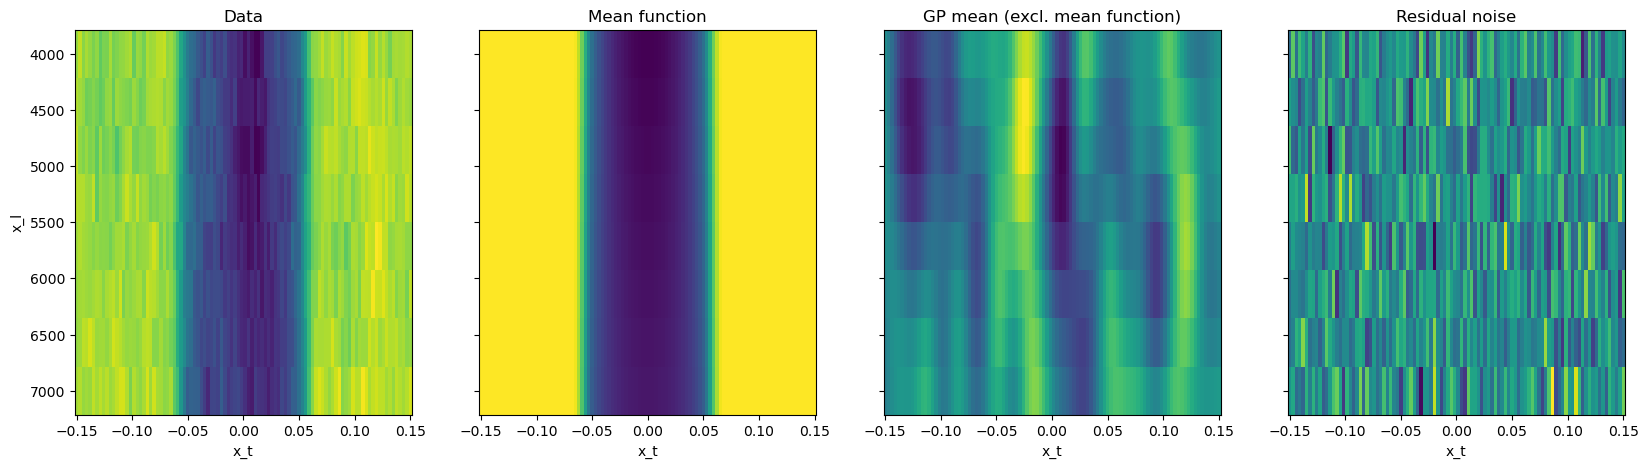

In [56]:
from luas import GP
from copy import deepcopy

# Initialise our GP object
# Make sure to include the mean function and log prior function if you're using them
gp = GP(kernel, x_l, x_t, mf = transit_light_curve_2D, logPrior = logPrior)

# Initialise our starting values as the true simulated values
p_initial = deepcopy(p_sim)

# Convenient function for plotting the data and the GP fit to the data
gp.plot(p_initial, Y)
print("Starting log posterior value:", gp.logP(p_initial, Y))

Now let's begin using ``NumPyro`` to perform a best-fit. We've already set the true simulated values as our initial values so we should already be close to the optimal log posterior value but for real data this won't always be the case. Similar to the approach in Fortune et al. (2024), we will not be performing any white light curve analysis but instead will be joint-fitting all spectroscopic light curves simultaneously

In [57]:
import numpyro
import numpyro.distributions as dist
from luas.numpyro_ext import LuasNumPyro
from copy import deepcopy

# Let's define some bounds
min_log_l_l = np.log(np.diff(x_l).min())
max_log_l_l = np.log(50*(x_l[-1] - x_l[0]))
min_log_l_t = np.log(np.diff(x_t).min())
max_log_l_t = np.log(3*(x_t[-1] - x_t[0]))

param_bounds = {
                # Bounds from Kipping (2013) at just between 0 and 1
                "q1":[jnp.array([0.]*N_l), jnp.array([1.]*N_l)],
                "q2":[jnp.array([0.]*N_l), jnp.array([1.]*N_l)],
    
                # Can optionally include bounds on other mean function parameters but often they will be well constrained by the data
                "rho":[jnp.array([0.]*N_l), jnp.array([1.]*N_l)],
    
                # Sometimes prior bounds on hyperparameters are important for sampling
                # However their choice can sometimes affect the results so use with caution
                "log_h":   [jnp.log(1e-6)*np.ones(1), jnp.log(1)*jnp.ones(1)],
                "log_l_l": [min_log_l_l*jnp.ones(1), max_log_l_l*jnp.ones(1)],
                "log_l_t": [min_log_l_t*jnp.ones(1), max_log_l_t*jnp.ones(1)],
                "log_sigma":[jnp.log(1e-6)*jnp.ones(N_l), jnp.log(1e-2)*jnp.ones(N_l)],
}

def transit_model(Y):
    # Makes of copy of any parameters to be kept fixed during sampling
    var_dict = deepcopy(p_initial)
    
    # Specify the parameters we've given bounds for
    var_dict["rho"] = numpyro.sample("rho", dist.Uniform(low = param_bounds["rho"][0],
                                                         high =param_bounds["rho"][1]))
    var_dict["log_h"] = numpyro.sample("log_h", dist.Uniform(low = param_bounds["log_h"][0],
                                                             high = param_bounds["log_h"][1]))
    var_dict["log_l_l"] = numpyro.sample("log_l_l", dist.Uniform(low = param_bounds["log_l_l"][0],
                                                                 high = param_bounds["log_l_l"][1]))
    var_dict["log_l_t"] = numpyro.sample("log_l_t", dist.Uniform(low = param_bounds["log_l_t"][0],
                                                                 high = param_bounds["log_l_t"][1]))
    var_dict["log_sigma"] = numpyro.sample("log_sigma", dist.Uniform(low = param_bounds["log_sigma"][0],
                                                                     high = param_bounds["log_sigma"][1]))
    var_dict["q1"] = numpyro.sample("q1", dist.Uniform(low = param_bounds["q1"][0], high = param_bounds["q1"][1]))
    var_dict["q2"] = numpyro.sample("q2", dist.Uniform(low = param_bounds["q2"][0], high = param_bounds["q2"][1]))
    
    # Specify the unbounded parameters
    var_dict["T0"] = numpyro.sample("T0", dist.ImproperUniform(dist.constraints.real, (),
                                                               event_shape = (1,)))
    var_dict["a"] = numpyro.sample("a", dist.ImproperUniform(dist.constraints.real, (),
                                                             event_shape = (1,)))
    var_dict["b"] = numpyro.sample("b", dist.ImproperUniform(dist.constraints.real, (),
                                                             event_shape = (1,)))
    var_dict["Foot"] = numpyro.sample("Foot", dist.ImproperUniform(dist.constraints.real, (),
                                                                   event_shape = (N_l,)))
    var_dict["Tgrad"] = numpyro.sample("Tgrad", dist.ImproperUniform(dist.constraints.real, (),
                                                                     event_shape = (N_l,)))

    numpyro.sample("log_like", LuasNumPyro(gp = gp, var_dict = var_dict), obs = Y)

Now we are all set up to start performing a best-fit using ``NumPyro``. Some of the variables here such as ``step_size`` and ``num_steps`` may need to be tweaked depending on the problem. Optimisation with ``NumPyro`` can be a bit awkward to use so it may help to try using the [numpyro-ext](https://github.com/dfm/numpyro-ext/tree/main) package which contains extensions to NumPyro including an easier to use optimiser

In [58]:
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer.initialization import init_to_value
from jax import random

step_size = 1e-5
num_steps = 5000

optimizer = numpyro.optim.Adam(step_size=step_size)
guide = AutoLaplaceApproximation(transit_model, init_loc_fn = init_to_value(values=p_initial))
svi = SVI(transit_model, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), num_steps, Y)
params = svi_result.params
p_fit = guide.median(params)

# Combine best-fit values with fixed values
p_opt = deepcopy(p_initial)
p_opt.update(p_fit)

print("Starting log posterior value:", gp.logP(p_initial, Y))
print("New optimised log posterior value:", gp.logP(p_opt, Y))

100%|████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 119.55it/s, init loss: -4813.4862, avg. loss [4751-5000]: -4836.1460]


Starting log posterior value: 4873.012553430895
New optimised log posterior value: 4895.770486304143


Although this probably won't be needed for the simulated data and will likely clip no data points, ``luas.GP`` comes with a ``sigma_clip`` method which performs 2D Gaussian process regression and can clip outliers that deviate from a given significance value and replace them with the GP predictive mean at those locations (note we need to maintain a complete grid structure and cannot remove these data points)

Number of outliers clipped =  0


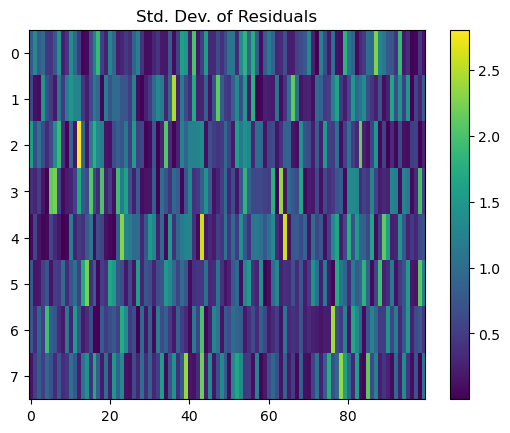

In [59]:
# This function will return a JAXArray of the same shape as Y
# but with outliers replaced with interpolated values
Y_clean = gp.sigma_clip(p_opt, # Make sure to perform sigma clipping using a good fit to the data
                        Y,     # Observations JAXArray
                        5.     # Significance level in standard deviations to clip at
                       )

For MCMC tuning with large numbers of parameters it can be very helpful to use the Laplace approximation to select a good choice of tuning matrix or "mass matrix" for No U-Turn Sampling. This can often return quite accurate approximations of the covariance matrix of the posterior especially when the data is clean enough to constrain most of the parameters.

Note that we use the ``gp.laplace_approx_with_bounds`` method instead of ``gp.laplace_approx`` because we have bounds on some of our parameters which means ``NumPyro`` will perform a transformation on these parameters we would like our Laplace approximation to take account of. See the ``gp.laplace_approx_with_bounds`` documentation for more details.

In [60]:
# Returns the covariance matrix returned by the Laplace approximation
# Also returns a list of parameters which is the order the array is in
# This matches the way jax.flatten_util.ravel_pytree will sort the parameter PyTree into
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(
    p_opt,               # Make sure to use best-fit values
    Y_clean,             # The observations being fit
    param_bounds,        # Specify the same bounds that will be used for the MCMC
    fixed_vars = ["P"],  # Make sure to specify fixed parameters as otherwise they are marginalised over
    return_array = True, # May optionally return a nested PyTree if set to False which can be more readable
    regularise = True,   # Often necessary to regularise values that return negative covariance
    large = False        # For large data sets with many parameters setting this to True is more memory efficient
)

No regularisation needed to remove negative values along diagonal of covariance matrix.


Build our model again using the same parameters being varied and sample all parameters using NUTS using ``NumPyro``

In [61]:
from numpyro.infer import MCMC, NUTS
from jax import random

# NumPyro makes use of the jax.random module to handle randomness
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

p_opt2 = deepcopy(p_opt)
del p_opt2["P"]
p_arr = jax.flatten_util.ravel_pytree(p_opt2)[0]
kernel_NUTS = NUTS(transit_model, # Our transit model specified earlier
                   init_strategy = init_to_value(values = p_opt), # Often works well to initialise near best-fit values
                   inverse_mass_matrix = cov_mat, # Inverse mass matrix is the same as the tuning covariance matrix
                   adapt_mass_matrix=False, # Often Laplace approximation works better than trying to tune many parameters
                   dense_mass = True,       # Need a dense mass matrix to account for correlations between parameters
                   regularize_mass_matrix = False)

mcmc = MCMC(
    kernel_NUTS,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    thinning=1,
    progress_bar=True,
)

mcmc.run(rng_key, Y)

# Generate an arviz inference data object from MCMC chains
idata = az.from_numpyro(mcmc)

/var/folders/lp/chmp1tb92f5_x_wdckqwk34c0000gn/T/ipykernel_25344/131176672.py:17: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.13it/s, 7 steps of size 4.72e-01. acc. prob=0.88]


Print a summary of the samples using ``arviz``

In [62]:
az.summary(idata, round_to = 4)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
Foot[0]       0.9999  0.0002  0.9995   1.0002     0.0000   0.0000  2384.1043   
Foot[1]       0.9997  0.0002  0.9993   1.0001     0.0000   0.0000  1914.7381   
Foot[2]       0.9998  0.0002  0.9994   1.0001     0.0000   0.0000  1714.4144   
Foot[3]       0.9998  0.0002  0.9995   1.0002     0.0000   0.0000  1462.8198   
Foot[4]       0.9997  0.0002  0.9993   1.0001     0.0000   0.0000  1330.8811   
Foot[5]       0.9999  0.0002  0.9996   1.0003     0.0000   0.0000  1447.4032   
Foot[6]       0.9999  0.0002  0.9996   1.0003     0.0000   0.0000  1699.8468   
Foot[7]       1.0002  0.0002  0.9999   1.0006     0.0000   0.0000  1933.6647   
T0[0]         0.0001  0.0004 -0.0006   0.0007     0.0000   0.0000  1770.2931   
Tgrad[0]      0.0001  0.0001 -0.0001   0.0002     0.0000   0.0000  2689.9279   
Tgrad[1]      0.0001  0.0001 -0.0000   0.0002     0.0000   0.0000  2503.5943   
Tgrad[2]      0.0001  0.0001 -0.0000   0.0003     0.0000   0.0000  2513.7666   
Tgrad[3]      0.0000  0.0001 -0.0001   0.0002     0.0000   0.0000  2296.8380   
Tgrad[4]      0.0000  0.0001 -0.0001   0.0002     0.0000   0.0000  2317.3853   
Tgrad[5]      0.0000  0.0001 -0.0001   0.0002     0.0000   0.0000  2385.2125   
Tgrad[6]     -0.0000  0.0001 -0.0001   0.0001     0.0000   0.0000  2450.2015   
Tgrad[7]      0.0001  0.0001 -0.0001   0.0002     0.0000   0.0000  2425.3516   
a[0]          8.0106  0.0578  7.8997   8.1138     0.0012   0.0008  2493.3643   
b[0]          0.5025  0.0088  0.4848   0.5178     0.0002   0.0001  2480.9087   
log_h[0]     -7.5726  0.1100 -7.7703  -7.3640     0.0028   0.0020  1632.5736   
log_l_l[0]    6.9339  0.1553  6.6484   7.2329     0.0040   0.0029  1478.1147   
log_l_t[0]   -4.7050  0.1197 -4.9229  -4.4872     0.0038   0.0027  1002.6346   
log_sigma[0] -7.5885  0.0800 -7.7378  -7.4368     0.0016   0.0011  2568.5541   
log_sigma[1] -7.6586  0.0798 -7.7989  -7.5001     0.0015   0.0011  2719.3918   
log_sigma[2] -7.7045  0.0800 -7.8571  -7.5598     0.0018   0.0012  2140.2838   
log_sigma[3] -7.6277  0.0801 -7.7671  -7.4737     0.0016   0.0012  2377.9148   
log_sigma[4] -7.5130  0.0792 -7.6657  -7.3681     0.0016   0.0011  2550.7797   
log_sigma[5] -7.7020  0.0736 -7.8502  -7.5761     0.0015   0.0011  2397.4635   
log_sigma[6] -7.8217  0.0862 -7.9752  -7.6591     0.0016   0.0011  3096.6037   
log_sigma[7] -7.4885  0.0808 -7.6307  -7.3330     0.0018   0.0013  1957.6704   
q1[0]         0.6469  0.0223  0.6063   0.6891     0.0004   0.0003  2822.7781   
q1[1]         0.5880  0.0207  0.5503   0.6282     0.0004   0.0003  2640.4494   
q1[2]         0.5478  0.0201  0.5079   0.5829     0.0004   0.0003  2509.6179   
q1[3]         0.5153  0.0192  0.4814   0.5525     0.0004   0.0003  2678.0187   
q1[4]         0.4738  0.0189  0.4401   0.5097     0.0004   0.0003  2696.0275   
q1[5]         0.4346  0.0181  0.3998   0.4664     0.0003   0.0002  2891.5757   
q1[6]         0.3967  0.0163  0.3666   0.4275     0.0003   0.0002  2661.5059   
q1[7]         0.3576  0.0165  0.3268   0.3896     0.0003   0.0002  2345.2777   
q2[0]         0.4369  0.0055  0.4272   0.4480     0.0001   0.0001  3026.5860   
q2[1]         0.4268  0.0057  0.4157   0.4371     0.0001   0.0001  2654.1803   
q2[2]         0.4142  0.0058  0.4038   0.4252     0.0001   0.0001  2607.7701   
q2[3]         0.3995  0.0057  0.3888   0.4099     0.0001   0.0001  2425.1990   
q2[4]         0.3853  0.0061  0.3731   0.3964     0.0001   0.0001  2253.7957   
q2[5]         0.3694  0.0060  0.3586   0.3811     0.0001   0.0001  2292.5811   
q2[6]         0.3522  0.0062  0.3411   0.3641     0.0001   0.0001  2778.2795   
q2[7]         0.3335  0.0061  0.3221   0.3446     0.0001   0.0001  2714.4752   
rho[0]        0.0982  0.0016  0.0953   0.1010     0.0000   0.0000  2153.9689   
rho[1]        0.0976  0.0015  0.0947   0.1004     0.0000   0.0000  2214.8006   
rho[2]        0.0994  0.0015  0.0966   0.1020     0.0000   0.0000  2233.9366   
rho[3]        0.

The ``arviz.plot_trace`` function can be very useful for visualising the marginal posterior distributions of the different parameters as well as to examine the chains and diagnose any possible convergence issues.

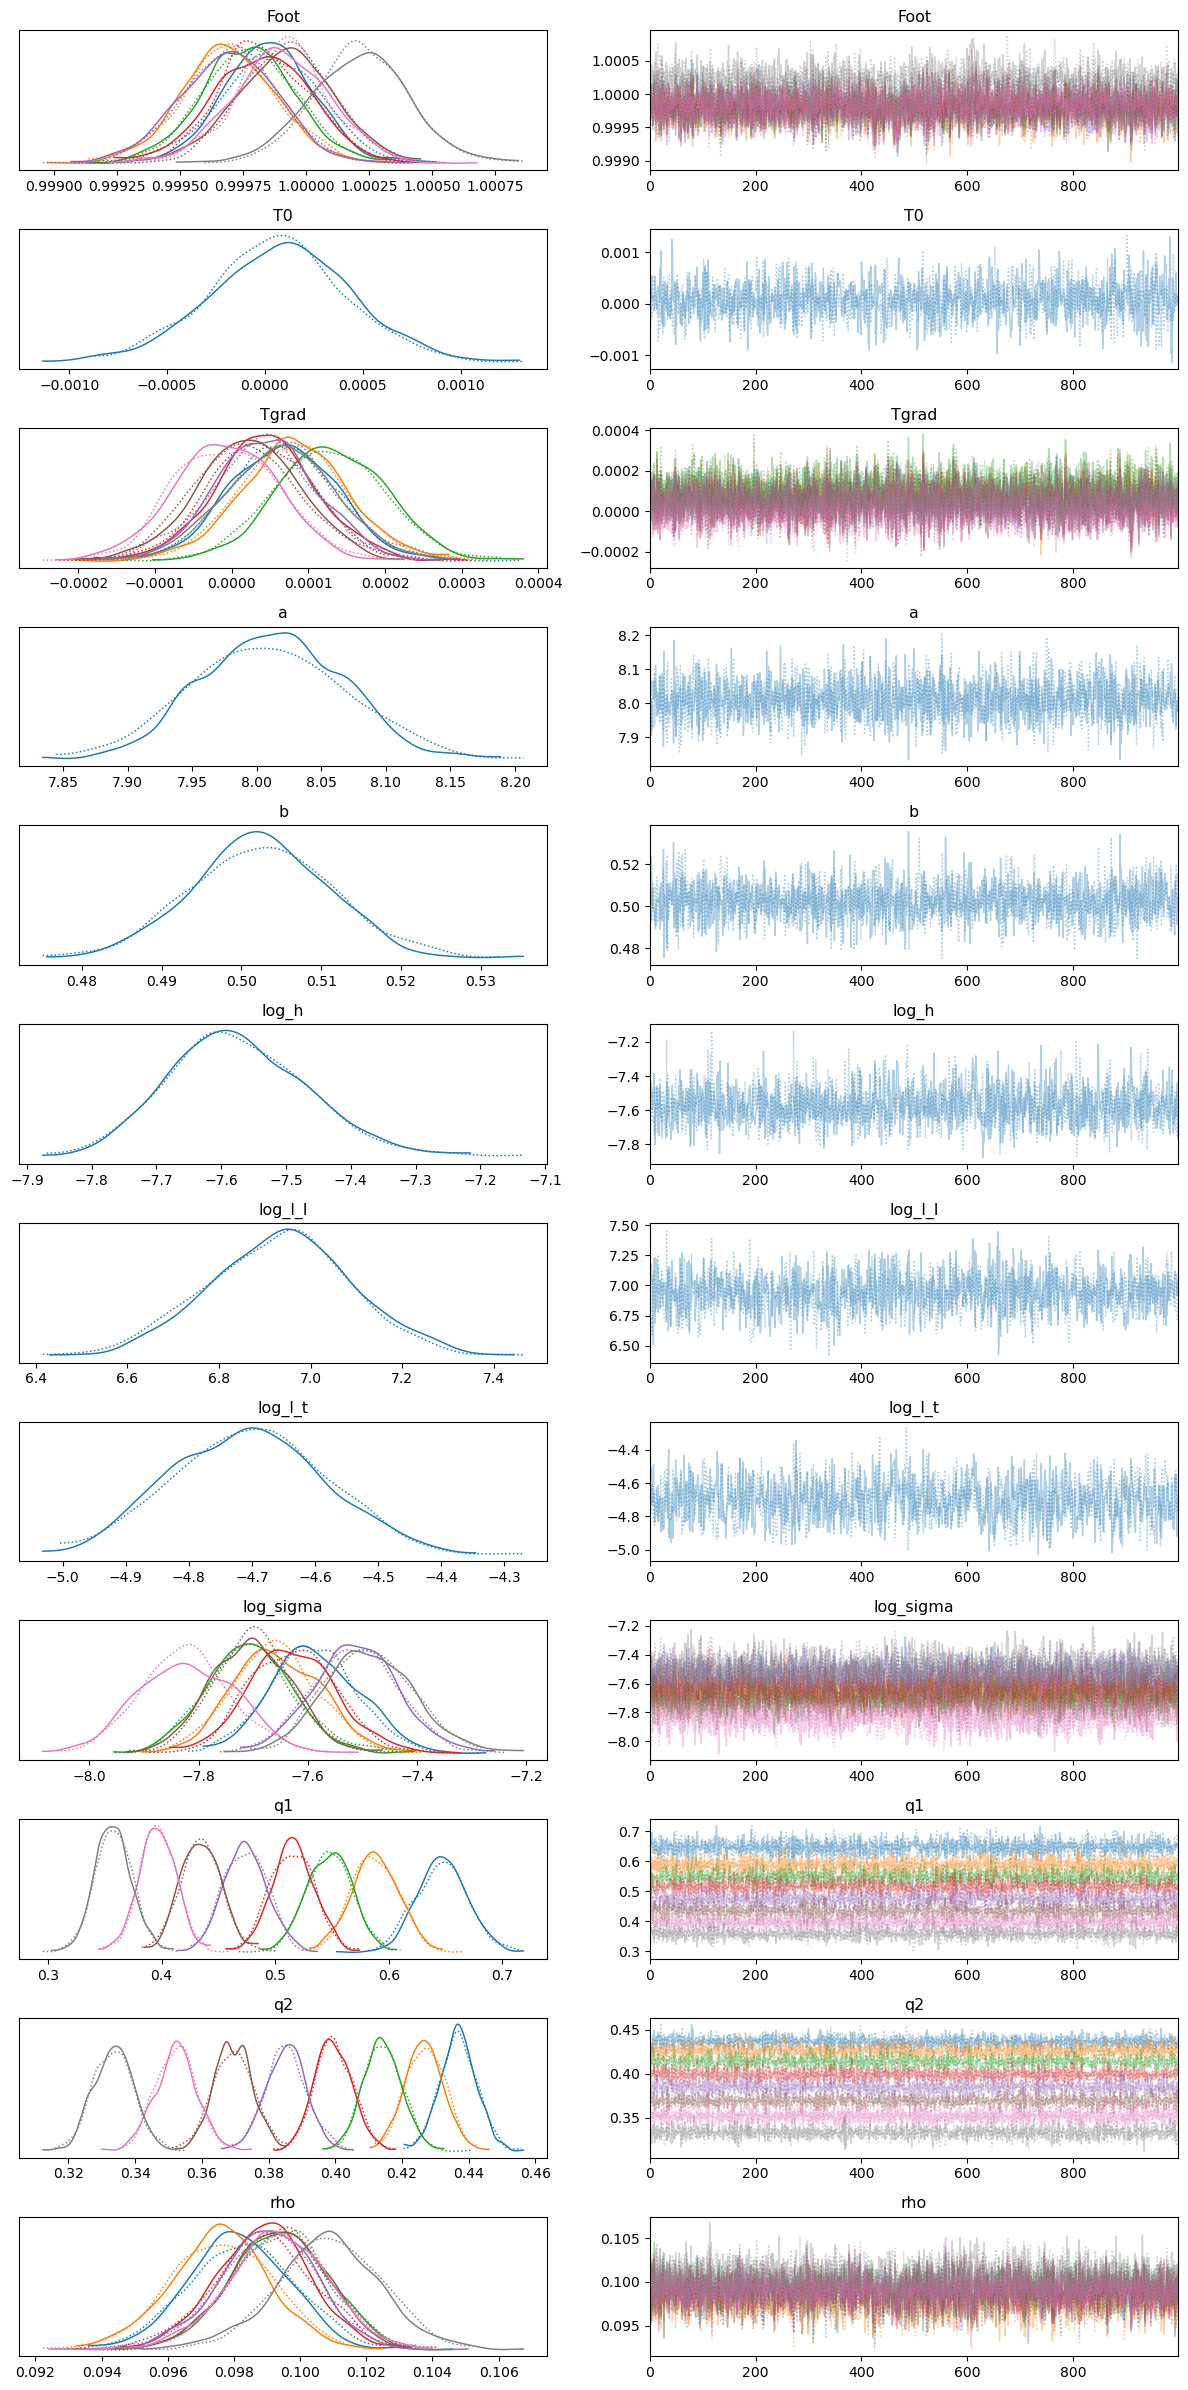

In [63]:
trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

``corner`` is a great module to use for generating corner plots. Unfortunately when fitting many light curves the number of parameters can make visualising the full corner plot quite unwieldly but we can always just plot subsets of parameters instead

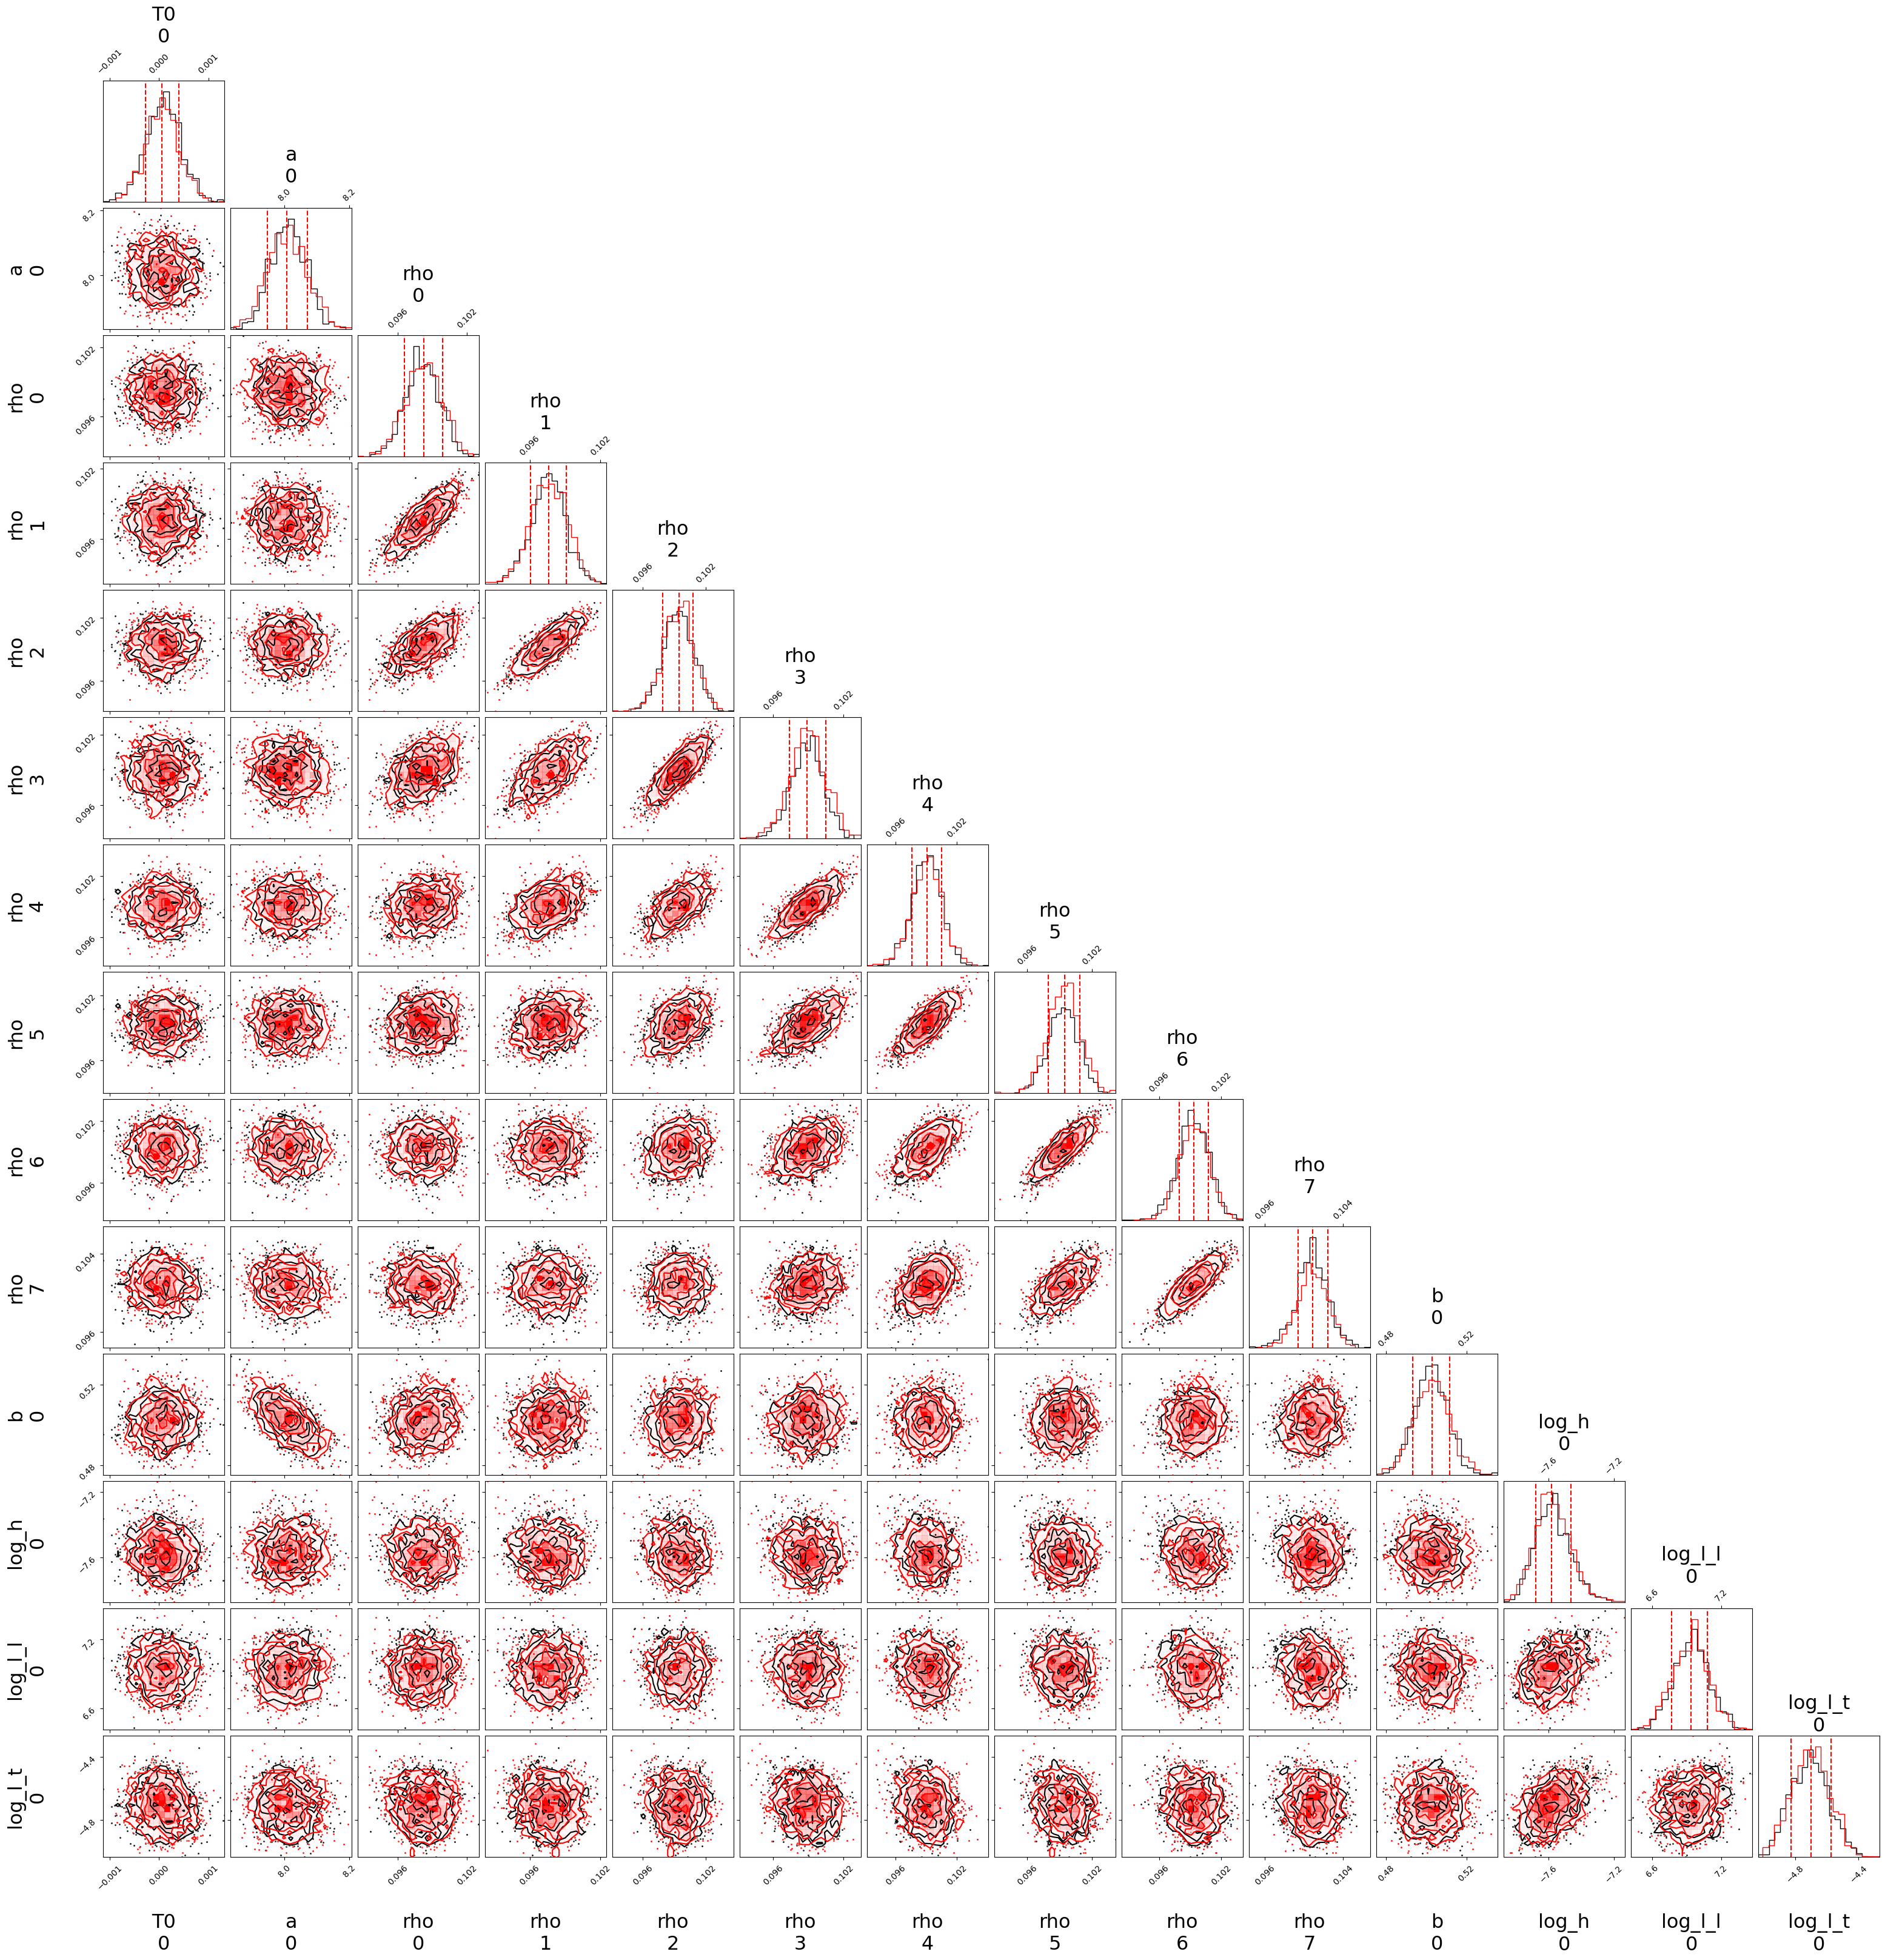

In [64]:
from corner import corner

idata_corner1 = idata.sel(chain=[0])
idata_corner2 = idata.sel(chain=[1])

params = ["T0", "a", "rho", "b", "log_h", "log_l_l", "log_l_t"]

fig1 = corner(idata_corner1, smooth = 0.4, var_names = params, data_kwargs = {"alpha":1.})
fig2 = corner(idata_corner2, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23}, label_kwargs={"fontsize": 23}, show_titles=True,
                     smooth = 0.4, color = "r", fig = fig1, top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params, data_kwargs = {"alpha":1.})

In [ ]:
def plot_predicted_lightcurves(x_l, x_t, model_curve, Y_pred, Y_pred_err, Y, save_name = ""):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 30), sharey = True)
    
    ax1.set_ylabel("Relative Flux")
    
    if "blue" in save_name:
        ax2.set_xlabel("Time [HJD] - 2457433")
        x_t_plot = x_t + 0.7558245
    
    if "red" in save_name:
        ax2.set_xlabel("Time [HJD] - 2457450")
        x_t_plot = x_t + 0.785372
    
    
    N_l = x_l.size
    
    
    sep_mag = 0.008 #Y.max() - Y.min()
    for i in range(N_l):
        errs = Y_pred_err[i, :]
        sep = np.arange(0, -sep_mag*N_l, -sep_mag)[i]
        
        #ax1.plot(x_t_plot, model_curve[i, :] + sep, 'b--')
        ax1.scatter(x_t_plot, Y[i, :] + sep, s=9, facecolors='k', edgecolors="k") #wavelength_to_rgb(x_l[i]/10))
        ax1.plot(x_t_plot, Y_pred[i, :] + sep, 'k-')
        
        ax1.plot(x_t_plot, Y_pred[i, :] + sep, 'r-')
        for j in [-2, -1, 1, 2]:
            ax1.plot(x_t_plot, Y_pred[i, :] + sep + j*errs, 'k-', linewidth = 0.5)
            
        ax1.fill_between(x_t_plot, Y_pred[i, :] + sep - errs, Y_pred[i, :] + sep + errs, color='k', alpha = 0.3)
        ax1.fill_between(x_t_plot, Y_pred[i, :] + sep - 2*errs, Y_pred[i, :] + sep + 2*errs, color='k', alpha = 0.3)
        
        ax2.scatter(x_t_plot, model_curve[i, 0] + Y[i, :] + sep - model_curve[i, :], s=9, facecolors='k', edgecolors="k") #wavelength_to_rgb(x_l[i]/10))
        ax2.plot(x_t_plot, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep, 'r-')
        for j in [-2, -1, 1, 2]:
            ax2.plot(x_t_plot, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep + j*errs, 'k-', linewidth = 0.5)
        ax2.fill_between(x_t_plot, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep - errs, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep + errs, color='k', alpha = 0.3)
        ax2.fill_between(x_t_plot, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep - 2*errs, model_curve[i, 0] + Y_pred[i, :] - model_curve[i, :] + sep + 2*errs, color='k', alpha = 0.3)
        
        ax3.scatter(x_t_plot, Y_pred[i, 30] + Y[i, :] + sep - Y_pred[i, :], s=9, facecolors='k', edgecolors="k") #wavelength_to_rgb(x_l[i]/10))
        ax3.plot(x_t_plot, np.ones(x_t.size)*Y_pred[i, 30] + sep, 'r-')
        for j in [-2, -1, 1, 2]:
            ax3.plot(x_t_plot, Y_pred[i, 30] + sep + j*errs, 'k-', linewidth = 0.5)
        ax3.fill_between(x_t_plot, Y_pred[i, 30] + sep - errs, Y_pred[i, 30] + sep + errs, color='k', alpha = 0.3)
        ax3.fill_between(x_t_plot, Y_pred[i, 30] + sep - 2*errs, Y_pred[i, 30] + sep + 2*errs, color='k', alpha = 0.3)
       
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

        # Increase size of ticks
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=12)
        ax.tick_params(which='minor', length=7)
        
    plt.gcf().subplots_adjust(left=0.08, right=0.97, top=0.98, bottom=0.05)
    plt.tight_layout()
    
    if save_name:
        plt.savefig(save_name, facecolor='w')
        plt.clf()
    else:
        plt.show()

If you want to examine the chains for any parameters you can use ``idata.posterior[param]`` to get an ``xarray.DataArray`` object and can use the ``to_numpy`` method to convert to a ``NumPy`` array

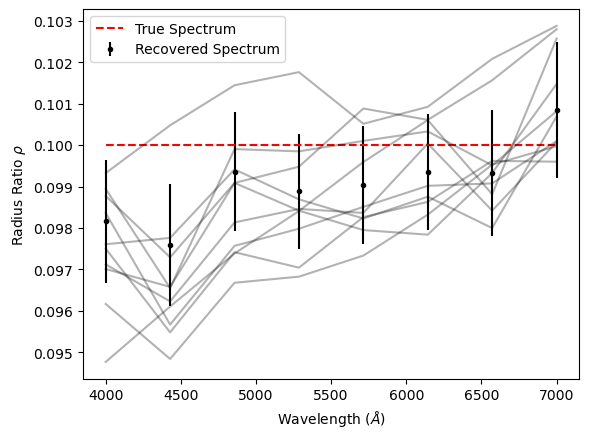

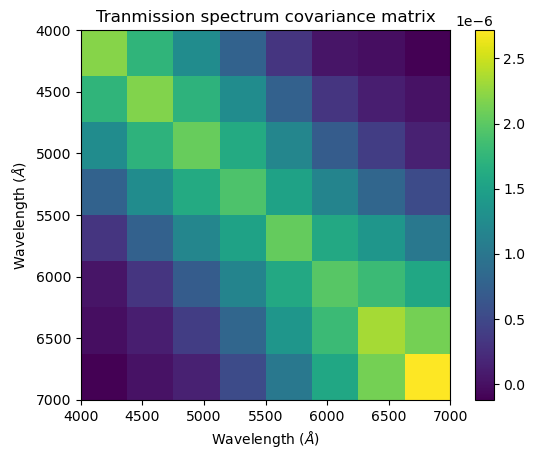

In [113]:
# NumPy array of MCMC samples of shape (N_chains, N_draws, N_l)
rho_chains = idata.posterior["rho"].to_numpy()

# Get the mean radius ratio values averaged over all chains and draws
rho_mean = rho_chains.mean((0, 1))

# Calculate the covariance matrix of each chain and average together
N_chains = rho_chains.shape[0]
rho_cov = jnp.zeros((N_l, N_l))
for i in range(N_chains):
    rho_cov += jnp.cov(rho_chains[0, :, :].T)
rho_cov /= N_chains

# Standard deviation given by sqrt of diagonal of covariance matrix
rho_std_dev = jnp.sqrt(jnp.diag(rho_cov))


# We can plot our recovered spectrum against the simulated true spectrum
plt.errorbar(x_l, rho_mean, yerr = rho_std_dev, fmt = 'k.', label = "Recovered Spectrum")
plt.plot(x_l, p_sim["rho"], 'r--', label = "True Spectrum")

# Select a few samples from the MCMC to help visualise the correlation between values
rho_draws = rho_chains[0, 0:1000:100, :].T
plt.plot(x_l, rho_draws, 'k-', alpha = 0.3)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"Radius Ratio $\rho$")
plt.legend()
plt.show()

plt.title("Tranmission spectrum covariance matrix")
plt.imshow(rho_cov, extent = [x_l[0], x_l[-1], x_l[-1], x_l[0]])
plt.colorbar()
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

It can be hard to tell when there are significant correlations involved whether the recovered spectrum is actually consistent with the simulated spectrum. The reduced chi-squared statistic $\chi_r^2$ is useful for determining this. It is calculated using:

$$
\begin{equation}
    \chi_\mathrm{r}^2 = (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj})^T \mathbf{K}_\mathrm{\vec{\rho}; ret}^{-1} (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj}) / N_l,
\end{equation}
$$

Where $\bar{\vec{\rho}}_\mathrm{ret}$ is our retrieved mean transmission spectrum, $\vec{\rho}_\mathrm{inj}$ is the injected transmission spectrum and $\mathbf{K}_\mathrm{\vec{\rho}; ret}$ is our retrieved covariance matrix of the transmission spectrum

In [111]:
r = rho_mean - p_sim["rho"]
chi2_r = r.T @ jnp.linalg.inv(rho_cov) @ r / N_l

print("Reduced chi-squared value:", chi2_r)

# The reduced chi-squared distribution always has mean 1 but has different standard deviation
# Depending on the numbers of degrees of freedom
print("Distribution of reduced chi-squared: mu = 1, sigma =", jnp.sqrt(2/N_l))

Reduced chi-squared value: 1.1960531174197462
Distribution of reduced chi-squared: mu = 1, sigma = 0.5


In [114]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data